# Computational pipeline in Python using `scikit-learn` and `pandas`

In this example we'll visualize, preprocess, and train a classification model for the well-known `iris` dataset. We'll use computational pipelines from `pandas` and `scikit-learn` to make this easy.

First, we'll install any needed dependencies:

In [1]:
%%capture
import sklearn
import sklearn.datasets
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Reproducibility: let's set the random seed.

In [2]:
import random
random.seed(0)
np.random.seed(0)

And load the `iris` dataset as a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), using `pandas` CSV reader:

In [3]:
inputs = pd.read_csv('inputs.csv')
targets = pd.read_csv('targets.csv')['target']

## Explore & visualize the data
Let's view some summary statistics of the data.

In [4]:
inputs.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000

Let's plot the input data in two dimensions, colored by the target, using principal components analysis.

In [5]:
def plot_2D(data: npt.NDArray):
    pca = PCA(n_components=2)
    X = pca.fit_transform(inputs.values)
    return plt.scatter(X[:,0], X[:,1], c=targets, cmap=plt.cm.Set1)

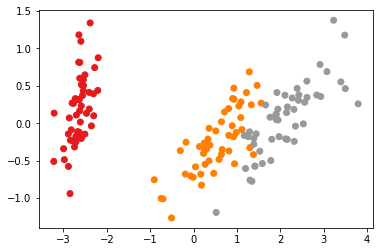

In [6]:
plot_2D(inputs)

## Preprocess the data
Before performing a classification, we often want to normalize and scale each feature by its mean and standard deviation. The formula for this is:

$$
\hat{x} = \frac{x - \mu}{\sigma}
$$

In [7]:
def normalize(data: pd.DataFrame) -> pd.DataFrame:
    data_ = data.copy()
    for column in data.columns:
        data_[column] = (data_[column] -  data_[column].mean()) /  data_[column].std()
    return data_

In [8]:
scaled_inputs = normalize(inputs)
scaled_inputs.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count       1.500000e+02      1.500000e+02       1.500000e+02   
mean       -5.684342e-16     -7.815970e-16      -2.842171e-16   
std         1.000000e+00      1.000000e+00       1.000000e+00   
min        -1.863780e+00     -2.425820e+00      -1.562342e+00   
25%        -8.976739e-01     -5.903951e-01      -1.222456e+00   
50%        -5.233076e-02     -1.315388e-01       3.353541e-01   
75%         6.722490e-01      5.567457e-01       7.602115e-01   
max         2.483699e+00      3.080455e+00       1.779869e+00   

       petal width (cm)  
count      1.500000e+02  
mean      -3.789561e-16  
std        1.000000e+00  
min       -1.442245e+00  
25%       -1.179859e+00  
50%        1.320673e-01  
75%        7.880307e-01  
max        1.706379e+00

## Feature selection
There are 6 possible combinations of 2-dimensional features we can select. Let's visualize them to see which ones separate the training data best.

In [9]:
def plot_features(data: pd.DataFrame, targets: pd.Series, f1: str, f2: str, ax):
    ax.scatter(data[f1], data[f2], c=targets, cmap=plt.cm.Set1)
    ax.title.set_text(f'{f1} vs {f2}')
    ax.axis('off')

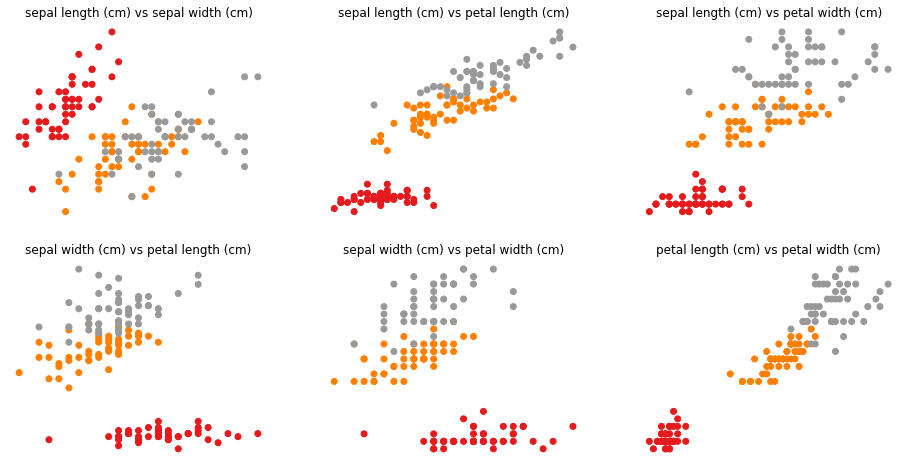

In [10]:
from itertools import combinations
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
i = 0
for (f1, f2) in combinations(inputs.columns, 2):
    row, col = i // 3, i % 3
    plot_features(scaled_inputs, targets, f1, f2, axs[row][col])
    i += 1

This suggests that `petal length * petal width` (petal area) may be a good 1-dimensional separating feature.

Based on this, we may either use one of the feature pairs above or the 2-dimensional PCA embedding. For simplicity we'll use `petal length` and `petal width`.

In [11]:
model_inputs = scaled_inputs[['petal length (cm)', 'petal width (cm)']]

## Training a model
We'll now feed our scaled and extracted features to a logistic regression model with regularization constant `C=1e5`.

In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e5)
model.fit(model_inputs.values, targets.values)

LogisticRegression(C=100000.0)

Now we'll plot the model's hypothesis.

In [13]:
def evaluate_hypothesis(inputs, targets, model):
    X = inputs.values
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return xx, yy, Z

def plot_hypothesis(inputs, targets, model):
    X = inputs.values
    xx, yy, Z = evaluate_hypothesis(inputs, targets, model)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Set1)
    plt.scatter(X[:, 0], X[:, 1], c=targets, edgecolors="k", cmap=plt.cm.Set1)
    plt.xlabel(inputs.columns[0])
    plt.ylabel(inputs.columns[1])
    plt.savefig('model.png')

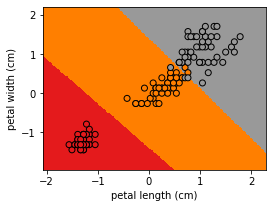

In [14]:
plot_hypothesis(model_inputs, targets, model)

In [15]:
def save_hypothesis(inputs, targets, model):
    xx, yy, Z = evaluate_hypothesis(inputs, targets, model)
    np.savetxt('model_xx.txt', xx, delimiter=',')
    np.savetxt('model_yy.txt', yy, delimiter=',')
    np.savetxt('model_Z.txt', Z, delimiter=',')

# Optionally save the hypothesis
# save_hypothesis(model_inputs, targets, model)

And our final accuracy is:

In [16]:
model.score(model_inputs.values, targets)

0.96

## Validate

In [17]:
def validate_hypothesis(inputs, targets, model):
    xx, yy, Z = evaluate_hypothesis(inputs, targets, model)
    v_xx = np.loadtxt('model_xx.txt', delimiter=',')
    v_yy = np.loadtxt('model_yy.txt', delimiter=',')
    v_Z = np.loadtxt('model_Z.txt', delimiter=',')
    assert np.allclose(v_xx, xx)
    assert np.allclose(v_yy, yy)
    assert np.allclose(v_Z, Z)
    print('Passed')

In [18]:
validate_hypothesis(model_inputs, targets, model)

Passed
